In [1]:
# =========================
# Libraries
# =========================

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.integrate import trapezoid
from scipy.interpolate import RegularGridInterpolator
import time
import emcee
from multiprocessing import Pool, cpu_count
import multiprocessing as mp
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

In [2]:
# =========================
# Loading BAO data (DESI_DR2)
# =========================

# Path
bao_dat_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/BAO/desi_gaussian_bao_ALL_GCcomb_mean.txt"
bao_cov_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/BAO/desi_gaussian_bao_ALL_GCcomb_cov.txt"

# DataFrame
df_bao = pd.read_csv(bao_dat_path, sep=r"\s+", comment="#", names=["z", "value", "quantity"])

# Main columns
z_bao = df_bao["z"].values
d_obs = df_bao["value"].values
q_obs = df_bao["quantity"].values

# Covariance matrix and its inverse
cov_bao = np.loadtxt(bao_cov_path)
Cinv_bao = np.linalg.inv(cov_bao)

In [3]:
# =========================
# Fiducial
# =========================

# Uniform priors
H0_min, H0_max = 50.0, 90.0
Om0_min, Om0_max = 0.1, 0.6
Ob_min, Ob_max = 0.047, 0.052
b_min, b_max = 1.6, 8.0

# Gaussian prior
mu_Ob, sigma_Ob = 0.0495, 0.0025

# Physical constant
c_kms = 299792.458

# Cosmological parameters
Or0 = 7.88e-5
Neff = 3.04

# Scalaron mass scale
delta_s = 1e-7

# Scale facor grid
ai, af, n_p = 0.2, 1.0, 1000
a_grid = np.linspace(ai, af, n_p)

# Redshift grid
zi, zf = 0.0, 4.0
z_grid = np.linspace(zi, zf, n_p)

In [4]:
# ==============================
# Stable numerical functions
# ==============================

# Stable log(cosh(x))
def stable_logcosh(x):

    # Absolute value of x
    abs_x = np.abs(x)

    # Switch to asymptotic form for numerical stability
    if abs_x < 20.0:
        return np.log(np.cosh(x))
    else:
        return abs_x - np.log(2.0)


# Stable tanh(x)
def stable_tanh(x):

    # Asymptotic saturation for large |x|
    if x > 20.0:
        return 1.0
    elif x < -20.0:
        return -1.0
    else:
        return np.tanh(x)


# Stable sech(x)
def stable_sech(x):
    
    # Absolute value of x
    abs_x = np.abs(x)
    
    # Switch to asymptotic form for numerical stability
    if abs_x < 20.0:
        return 1.0 / np.cosh(x)
    else:
        return 2.0 * np.exp(-abs_x)


# ============================================================
# Curvature scale in the AB f(R) model
# ============================================================

def compute_epsilon(H0, b):
    
    # Vacuum curvature scale
    R_vac = 12.0 * H0**2

    # Stable evaluation of log(1 + exp(2b))
    if b < 20.0:
        L = np.log1p(np.exp(2.0 * b))
    else:
        L = 2.0 * b + np.exp(-2.0 * b)

    return R_vac / L

In [5]:
# ============================================================
# ODE system for the Hubble parameter in the AB model
# ============================================================

def Hubble_AB_a(a, y, H0, Om0, b):
    """
    System of ordinary differential equations for the Hubble
    parameter H(a) in the AB f(R) gravity model.

    The system evolves H and its first two derivatives with
    respect to the scale factor a.
    """

    # Hubble parameter and its 1st and 2nd derivatives 
    H, dH, ddH = y

    # Matter and radiation density parameters
    Om = Om0 * a**(-3)
    Or = Or0 * a**(-4)

    # Effective curvature scale from the AB model
    epsilon = compute_epsilon(H0, b)

    # Squadred scalaron rest mass
    M2 = epsilon / delta_s

    # Ricci (curvature) scalar
    R = 6.0 * H * (2.0 * H + a * dH)

    # Normalized curvature scalar shifted by the model parameter b
    alpha = (R / epsilon) - b

    # Numerically stable hyperbolic functions
    tanh_a = stable_tanh(alpha)
    sech_a = stable_sech(alpha)


    # ===============================
    # ODE terms : A, B, C, D, E, F
    # ===============================

    A = H0**2 * (3.0*Om + 4.0*Or)

    B = a * H * dH * (tanh_a + 1.0)

    C = ( 4.0 * a * H**2 * dH * (a * dH + 2.0 * H) / M2 )

    D = ( ((6.0 * a**2 * H**2) / epsilon)**2 * ((5.0 * dH / a) + (dH**2 / H) + ddH)**2 * tanh_a * (sech_a**2) )

    E = ( 6.0 * a**3 * H**3 * (1.0 / (3.0 * M2) + 0.5 * (sech_a**2) / epsilon) )

    # Avoid singularities and non-finite evolution
    if E == 0 or not np.isfinite(E):
        return [np.nan, np.nan, np.nan]

    F = ( (11.0 * dH**2) / (a * H) + (dH**3) / (H**2) + (6.0 * ddH / a) + (4.0 * dH * ddH / H) )


    # 3rd derivative of the Hubble parameter
    dddH = -( (A + B + C - D) / E) - F

    # Return 1st, 2nd, and 3rd derivatives of H
    return [dH, ddH, dddH]


# ============================================================
# ODE integration for obtaining H(a)
# ============================================================

def H_AB_a(a_grid, H0, Om0, b):
    """
    Numerical solution for the Hubble parameter H(a) in the
    AB f(R) gravity model.

    The integration is initialized at a = a_i using LCDM
    initial conditions and evolved up to a = a_f.
    """

    # ---------------------------------
    # Initial conditions according to the LCDM model at ai = 0.2
    # ---------------------------------
    
    # Initial matter and radiation density parameters
    Omi = Om0 * ai**(-3)
    Ori = Or0 * ai**(-4)

    # Cosmological constant density parameter
    Ol0 = 1.0 - Om0 - Or0

    # Initial Hubble parameter H(ai)
    Hi = H0 * np.sqrt(Omi + Ori + Ol0)

    # Initial 1st derivative dH/da at ai
    dHi = - ( (H0**2) / (2.0 * ai * Hi) ) * (3.0 * Omi + 4.0 * Ori)

    # Initial 2nd derivative d²H/da² at ai
    ddHi = ( 0.5 * (H0 / (ai * Hi))**2 * (Hi + ai * dHi) * (3.0 * Omi + 4.0 * Ori)
        + 0.5 * (H0 / (ai * Hi))**2 * Hi * (9.0 * Omi + 16.0 * Ori) )

    # Initial state vector
    y0 = [Hi, dHi, ddHi]

    
    # ---------------------------------
    # Numerical integration
    # ---------------------------------

    sol = solve_ivp(Hubble_AB_a, (ai, af), y0, t_eval=a_grid, method="LSODA", rtol=1e-6, atol=1e-9, args=(H0, Om0, b))

    # Check integration success and numerical validity
    if sol.status < 0 or np.any(~np.isfinite(sol.y)):
        return None

    # Return H(a) evaluated on the input grid
    return sol.y[0]


# ============================================================
# Conversion to H(z)
# ============================================================

def H_AB_z(z_grid, H0, Om0, b):
    """
    Compute the Hubble parameter H(z) in the Appleby-Battye (AB) model.

    This function acts as a wrapper for the scale-factor-based ODE solver. 
    It is designed to be robust for both individual float inputs and 
    NumPy arrays (such as the 'z' column from a BAO dataset).

    Input Handling:
    - If z_grid is a scalar: Returns a single float H(z).
    - If z_grid is an array: Returns a NumPy array H(z) maintaining 
      the original input order, regardless of the internal monotonic 
      integration requirements.

    Parameters:
    -----------
    z_grid : float or array_like
        Redshift(s) at which to evaluate H(z).
    H0, Om0, b : float
        Cosmological and model-specific parameters.

    Returns:
    --------
    H_z : float or ndarray
        The Hubble parameter at the requested redshift(s).
    """
    
    # Ensure input is treated as an array for consistent indexing logic
    z_array = np.atleast_1d(z_grid)
    
    # Convert redshift to scale factor: a = 1 / (1 + z)
    a_values = 1.0 / (1.0 + z_array)

    # solve_ivp requires a strictly monotonic integration interval.
    # Since z_bao might not be sorted, we sort 'a' to ensure stability.
    sort_idx = np.argsort(a_values)
    a_sorted = a_values[sort_idx]

    # Solve the ODE system on the sorted scale factor grid
    H_sorted = H_AB_a(a_sorted, H0, Om0, b)
    
    if H_sorted is None:
        return None

    # Map the results back to the original order of the input z_grid
    # This is crucial for matching the sequence of the BAO data vector
    H_z = np.empty_like(H_sorted)
    H_z[sort_idx] = H_sorted

    # Return scalar if input was scalar, else return the array
    return H_z[0] if np.isscalar(z_grid) else H_z

In [ ]:
# ============================================================
# Comoving distance
# ============================================================

def comoving_distance(z, H0, Om0, b):
    """
    Comoving distance:
        D_M(z) = c * ∫ dz / H(z)
    """

    # Redshift grid used for numerical integration
    z_samples = np.linspace(0.0, z, 1000)

    # Integrand of the Hubble Distance: 1 / H(z) for c = 1 
    y = 1.0 / H_AB_z(z_samples, H0, Om0, b)

    # Numerical integration over redshift
    integral = trapezoid(y, z_samples)

    # Comoving distance in units of Mpc
    return c_kms * integral


# ============================================================
# Sound horizon
# ============================================================

def sound_horizon_rd(H0, Om0, Ob):
    """
    Sound horizon at drag epoch (r_d), in Mpc
    """

    # Dimensionless Hubble parameter squared: h ≡ H0 / 100 (km/s/Mpc)
    h2 = (H0 / 100.0)**2

    # Sound horizon fitting formula
    rd = (
        147.05
        * (Ob * h2 / 0.02236)**(-0.13)
        * (Om0 * h2 / 0.1432)**(-0.23)
        * (Neff / 3.04)**(-0.10)
        )

    return rd


# ============================================================
# BAO observables
# ============================================================

# Transverse BAO distance (scaled by rd)
def DM_over_rd(z, H0, Om0, Ob, b):
    """
    D_M(z) / r_d
    """

    # Sound horizon
    rd = sound_horizon_rd(H0, Om0, Ob)

    # Comoving distance
    DC = comoving_distance(z, H0, Om0, b)

    return DC / rd


# Hubble distance (scaled by rd)
def DH_over_rd(z, H0, Om0, Ob, b):
    """
    D_H(z) / r_d = c / [H(z) r_d]
    """
    
    # Redshift array
    z_array = np.array([z])

    rd = sound_horizon_rd(H0, Om0, Ob)
    Hz = H_AB_z(z_array, H0, Om0, b)

    return c_kms / (rd * Hz[0])


# Volume-averaged distance (scaled by rd)
def DV_over_rd(z, H0, Om0, Ob, b):
    """
    D_V(z) / r_d
    """

    dm = DM_over_rd(z, H0, Om0, Ob, b)
    dh = DH_over_rd(z, H0, Om0, Ob, b)

    return (z * dm**2 * dh)**(1.0 / 3.0)


# ==============================
# Theoretical BAO distance vector (following the d_obs sequence)
# ==============================

def d_AB(z_bao, q_obs, H0, Om0, Ob, b):
    """
    Builds the theoretical BAO vector following the order
    given by (z_bao, quantities).
    """
    d_theory = []

    for z, q in zip(z_bao, q_obs):

        if q in ["DM_over_rs"]:
            d_theory.append(DM_over_rd(z, H0, Om0, Ob, b))

        elif q in ["DH_over_rs"]:
            d_theory.append(DH_over_rd(z, H0, Om0, Ob, b))

        elif q in ["DV_over_rs"]:
            d_theory.append(DV_over_rd(z, H0, Om0, Ob, b))

        else:
            raise ValueError(f"Unknown BAO quantity: {q}")

    return np.array(d_theory)


# ========================
# Sanity test
# ========================

print("d_AB(z_bao) =", d_AB(z_bao, q_obs, 70, 0.3, 0.0495, 8))

d_AB(z_bao) = [ 7.91966585 13.28349041 22.49522385 17.44477058 20.01110178 21.71093991
 17.4770476  27.77552393 14.032997   29.9654591  12.86188794  8.62510055
 38.87197352]


In [7]:
# ==============================
# Parameter grids
# ==============================

n_H0 = n_Om0 = n_Ob = n_b = 7

H0_grid  = np.linspace(H0_min, H0_max, n_H0)
Om0_grid = np.linspace(Om0_min, Om0_max, n_Om0)
Ob_grid  = np.linspace(Ob_min, Ob_max, n_Ob)
b_grid   = np.linspace(b_min,  b_max,  n_b)

# Length of BAO data vector
n_data = len(z_bao)


# ==============================
# Grid point evaluator
# ==============================

def grid_point(args):
    """
    Computes the BAO theory vector at a single grid point.
    """
    
    i, j, k, l = args

    H0  = H0_grid[i]
    Om0 = Om0_grid[j]
    Ob  = Ob_grid[k]
    b   = b_grid[l]

    try:
        vals = d_AB(z_bao, q_obs, H0, Om0, Ob, b)

        if vals is None or np.any(~np.isfinite(vals)):
            return (i, j, k, l, None)

        return (i, j, k, l, vals)

    except Exception:
        return (i, j, k, l, None)


# ==============================
# Parallel grid construction
# ==============================

def build_BAO_grid():
    """
    Builds the full BAO theory grid using multiprocessing.
    """

    grid = np.full(
        (n_H0, n_Om0, n_Ob, n_b, n_data),
        np.nan,
        dtype=float
    )

    tasks = [
        (i, j, k, l)
        for i in range(n_H0)
        for j in range(n_Om0)
        for k in range(n_Ob)
        for l in range(n_b)
    ]

    total = len(tasks)
    print(f"Total grid points: {total}")
    print(f"Using {cpu_count()} CPUs")

    t0 = time.time()

    completed = 0
    next_checkpoint = 10  # percent

    with Pool(cpu_count()) as pool:
        for i, j, k, l, vals in pool.imap_unordered(grid_point, tasks):

            completed += 1
            percent = 100 * completed / total

            if percent >= next_checkpoint:
                print(f"{next_checkpoint}% concluído ({completed}/{total})")
                next_checkpoint += 10

            if vals is not None:
                grid[i, j, k, l, :] = vals

    tf = time.time()
    print(f"100% concluído")
    print(f"Grid built in {(tf - t0)/60:.2f} minutes")

    return grid


# ==============================
# BAO interpolator (4D → vector)
# ==============================

bao_grid = build_BAO_grid()

bao_interp_4D = RegularGridInterpolator(
    (H0_grid, Om0_grid, Ob_grid, b_grid),
    bao_grid,
    bounds_error=False,
    fill_value=np.nan
)

Total grid points: 2401
Using 112 CPUs
10% concluído (241/2401)
20% concluído (481/2401)
30% concluído (721/2401)
40% concluído (961/2401)
50% concluído (1201/2401)
60% concluído (1441/2401)
70% concluído (1681/2401)
80% concluído (1921/2401)
90% concluído (2161/2401)
100% concluído (2401/2401)
100% concluído
Grid built in 1.03 minutes


In [8]:
# ==============================
# Interpolated BAO theory vector
# ==============================

def d_AB_interp(H0, Om0, Ob, b):
    """
    Interpolated BAO theory vector in the AB model.
    """

    # Interpolation point (order MUST match the grid)
    pt = np.array([H0, Om0, Ob, b], dtype=float)

    # Interpolate
    d_vals = bao_interp_4D(pt).squeeze()

    return d_vals


#  ========================
# Sanity test
# ========================

print("d_AB_interp(z_bao) =", d_AB_interp(70, 0.3, 0.0495, 8))

d_AB_interp(z_bao) = [ 7.90547531 13.26090992 22.46705657 17.41805645 19.9968503  21.68255416
 17.47595708 27.74962049 14.04519288 29.9417998  12.87702431  8.64373667
 38.86351797]


In [9]:
# =========================================
# BAO Likelihood (DESI_DR2)
# =========================================

# Log-priors
def lnprior_bao(theta_bao):
    
    # Params vector
    H0, Om0, Ob, b = theta_bao
    
    # Flat priors
    if not (H0_min <= H0 <= H0_max):     return -np.inf
    if not (Om0_min <= Om0 <= Om0_max):  return -np.inf
    if not (b_min <= b <= b_max):        return -np.inf

    # Gaussian prior on Omega_b
    lp_Ob = -0.5 * ((Ob - mu_Ob)**2 / sigma_Ob**2) - np.log(sigma_Ob * np.sqrt(2*np.pi))
    
    return lp_Ob


# Log-likelihood
# def lnlike_bao(theta_bao, z_bao, q_obs, d_obs, Cinv_bao):
def lnlike_bao(theta_bao, z_bao, d_obs, Cinv_bao):

    H0, Om0, Ob, b = theta_bao

    # Theoretical BAO distance vector
    # d_model = d_AB(z_bao, q_obs, H0, Om0, Ob, b)
    d_model = d_AB_interp(H0, Om0, Ob, b)
    if d_model is None or np.any(~np.isfinite(d_model)):
        return -np.inf
    
    # Residual vector
    delta = d_obs - d_model

    # Chi-squared
    chi2_bao = np.dot(delta, np.dot(Cinv_bao, delta))
    if not np.isfinite(chi2_bao):
        return -np.inf
    
    return -0.5 * chi2_bao


# Log-posterior
# def lnprob_bao(theta_bao, z_bao, q_obs, d_obs, Cinv_bao):
def lnprob_bao(theta_bao, z_bao, d_obs, Cinv_bao):

    # Log-prior
    lp = lnprior_bao(theta_bao)
    if not np.isfinite(lp):
        return -np.inf
    
    # Log-likelihood
    # ll = lnlike_bao(theta_bao, z_bao, q_obs, d_obs, Cinv_bao)
    ll = lnlike_bao(theta_bao, z_bao, d_obs, Cinv_bao)

    return lp + ll


# =========================
# Quick test
# =========================

theta_bao_test = [70, 0.3, 0.0495, 6.4]
print("AB_BAO log-posterior =", lnprob_bao(theta_bao_test, z_bao, d_obs, Cinv_bao))
# print("AB_BAO log-posterior =", lnprob_bao(theta_bao_test, z_bao, q_obs, d_obs, Cinv_bao))

AB_BAO log-posterior = -0.06860930678282351


In [10]:
# =========================
# MCMC configuration
# =========================

# Dimensions and sampling settings
ndim, nwalkers, nsteps, nburn = 4, 40, 53500, 3500
rng = np.random.default_rng(42)

# Initial walker positions drawn from priors
p0 = np.zeros((nwalkers, ndim))
p0[:,0] = rng.uniform(H0_min, H0_max, size=nwalkers)         # uniform H0
p0[:,1] = rng.uniform(Om0_min, Om0_max, size=nwalkers)       # uniform Omega_m0
p0[:,2] = rng.normal(mu_Ob, sigma_Ob, nwalkers)              # Gaussian Omega_b
p0[:,3] = rng.uniform(b_min, b_max, size=nwalkers)           # uniform b


# Parallel chain generation (MORE efficient for AB_BAO)
with mp.Pool(processes=nwalkers) as pool:
    # sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_bao, args=(z_bao, q_obs, d_obs, Cinv_bao), pool=pool)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_bao, args=(z_bao, d_obs, Cinv_bao), pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)

# Single-threaded chain generation (LESS efficient for AB_BAO)
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_bao, args=(z_bao, q_obs, d_obs, Cinv_bao))
# sampler.run_mcmc(p0, nsteps, progress=True)


# Full chain: shape (nsteps, nwalkers, ndim)
chain = sampler.get_chain()
# np.save("chain_AB_bao_grid.npy", chain)

# Flattened chain after burn-in: shape (N_total, ndim)
flat_samples = sampler.get_chain(discard=nburn, flat=True)
np.save("flat_samples_AB_bao_grid.npy", flat_samples)

  0%|          | 0/53500 [00:00<?, ?it/s]/home/brunowesley/projetos/venv/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 53500/53500 [01:44<00:00, 511.71it/s]


Removed no burn in


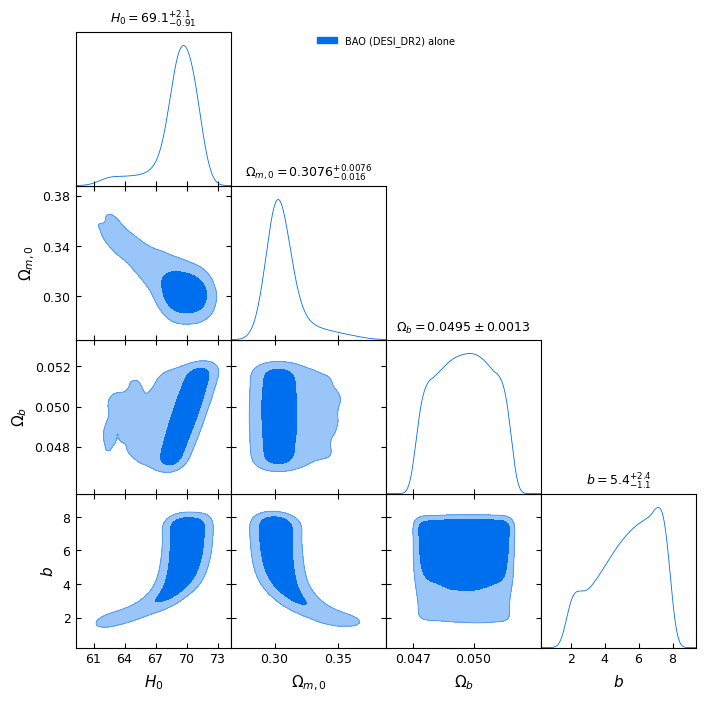

In [11]:
# =========================
# Corner plot using GetDist
# =========================

# Parameter names and LaTeX labels
param_names  = ["H0", "Omega_m0", "Omega_b", "b"]
param_labels = [r"H_0", r"\Omega_{m,0}", r"\Omega_b", r"b"]


# Create GetDist samples object
samples = MCSamples(
    samples=flat_samples,
    names=param_names,
    labels=param_labels
)

# Smoothing and binning settings
samples.updateSettings({
    "smooth_scale_1D": 0.25,
    "smooth_scale_2D": 0.25,
    "fine_bins": 1024,
    "fine_bins_2D": 1024

})


# Parameter ranges (optional)
# samples.setRanges({
#     "param p1": (p1_min, p1_max),
#     "param p2": (p2_min, p2_max),
#     "param p3": (p3_min, p3_max)
# })


# Initialize GetDist subplot plotter
g = plots.get_subplot_plotter()

# Plot styling settings
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.settings.legend_fontsize = 10
g.settings.linewidth_contour = 1.2
g.settings.num_plot_contours = 2
g.settings.axis_marker_lw = 1.0
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.3


# Triangle (corner) plot
g.triangle_plot(
    samples,
    filled=True,
    legend_labels=["BAO (DESI_DR2) alone"],
    #contour_colors=["#"],
    title_limit=1
)

# Save figure
plt.savefig("triangle_AB_bao_grid.png", dpi=300, bbox_inches="tight")
plt.show()